In [1]:
!git clone https://github.com/google-research/proteinfer 
!pip install -q -r proteinfer/requirements.txt
%cd proteinfer


Cloning into 'proteinfer'...
remote: Enumerating objects: 612, done.
remote: Counting objects: 100% (335/335), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 612 (delta 113), reused 160 (delta 31), pack-reused 277
Receiving objects: 100% (612/612), 88.74 MiB | 26.54 MiB/s, done.
Resolving deltas: 100% (252/252), done.
     |████████████████████████████████| 99 kB 5.4 MB/s 
     |████████████████████████████████| 2.3 MB 37.1 MB/s 
     |████████████████████████████████| 10.8 MB 51.6 MB/s 
     |████████████████████████████████| 2.8 MB 50.4 MB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 
     |████████████████████████████████| 59 kB 7.0 MB/s 
     |████████████████████████████████| 89 kB 10.8 MB/s 
     |████████████████████████████████| 56 kB 6.0 MB/s 
     |████████████████████████████████| 17.3 MB 52 kB/s 
     |████████████████████████████████| 10.5 MB 25.5 MB/s 
     |████████████████████████████████| 107 kB 68.4 MB/s 
     |████████████████████

In [2]:
!cd proteinfer
!ls

/bin/bash: line 0: cd: proteinfer: No such file or directory
baseline_utils.py	  install_models.py	   protein_model_test.py
baseline_utils_test.py	  LICENSE		   README.md
colab_evaluation.py	  misc			   requirements.txt
colab_evaluation_test.py  parenthood_bin.py	   testdata
colabs			  parenthood_lib.py	   test_util.py
CONTRIBUTING.md		  parenthood_lib_test.py   test_util_test.py
evaluation.py		  protein_dataset.py	   train.py
evaluation_test.py	  protein_dataset_test.py  train_test.py
hparams_sets.py		  proteinfer.py		   utils.py
inference.py		  proteinfer_test.py	   utils_test.py
inference_test.py	  protein_model.py


In [3]:
import inference
import pandas as pd
import evaluation
import parenthood_lib

import re

# Parse Price's ground truth labels

In [4]:
!wget https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/colab_support/price_enzymes.tsv

--2021-09-13 02:01:43--  https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/colab_support/price_enzymes.tsv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400317 (391K) [application/octet-stream]
Saving to: ‘price_enzymes.tsv’

price_enzymes.tsv   100%[===================>] 390.93K  --.-KB/s    in 0.004s  

2021-09-13 02:01:43 (93.7 MB/s) - ‘price_enzymes.tsv’ saved [400317/400317]



In [5]:
with open('price_enzymes.tsv') as f:
  price_enzymes = pd.read_csv(f, sep='\t')

In [6]:
price_enzymes_w_annotation = price_enzymes[price_enzymes.new_annotation.apply(lambda x: x.count('EC ') == 1)].copy()

# Predict for these sequences

In [7]:
!wget https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/models/zipped_models/noxpnd_cnn_swissprot_ec_random_swiss-cnn_for_swissprot_ec_random-13685140.tar.gz

--2021-09-13 02:01:43--  https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/models/zipped_models/noxpnd_cnn_swissprot_ec_random_swiss-cnn_for_swissprot_ec_random-13685140.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134391480 (128M) [application/octet-stream]
Saving to: ‘noxpnd_cnn_swissprot_ec_random_swiss-cnn_for_swissprot_ec_random-13685140.tar.gz’

noxpnd_cnn_swisspro 100%[===================>] 128.17M   111MB/s    in 1.2s    

2021-09-13 02:01:45 (111 MB/s) - ‘noxpnd_cnn_swissprot_ec_random_swiss-cnn_for_swissprot_ec_random-13685140.tar.gz’ saved [134391480/134391480]



In [8]:
!tar xzf noxpnd_cnn_swissprot_ec_random_swiss-cnn_for_swissprot_ec_random-13685140.tar.gz

In [9]:
inferrer = inference.Inferrer('noxpnd_cnn_swissprot_ec_random_swiss-cnn_for_swissprot_ec_random-13685140', use_tqdm=True)

W0913 02:01:47.257570 140413780555648 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/ragged/ragged_tensor.py:1586: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
predictions = inferrer.get_activations(list(price_enzymes_w_annotation.protein_sequence))

Annotating batches of sequences: 100%|██████████| 3/3 [01:08<00:00, 26.95s/it]


In [11]:
# Turn prediction array into actual labels by using the vocab.
cnn_label_vocab = inferrer.get_variable('label_vocab:0').astype(str)
price_enzymes_w_annotation['predicted_label'] = evaluation.filter_predictions_to_above_threshold(predictions, 0.148222, cnn_label_vocab) # Threshold is that which maximizes f1 score.

In [12]:
!wget https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/colab_support/parenthood.json.gz

--2021-09-13 02:02:56--  https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/colab_support/parenthood.json.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 992539 (969K) [application/octet-stream]
Saving to: ‘parenthood.json.gz’

parenthood.json.gz  100%[===================>] 969.28K  --.-KB/s    in 0.007s  

2021-09-13 02:02:57 (138 MB/s) - ‘parenthood.json.gz’ saved [992539/992539]



In [13]:
# Find the most specific label(s) given to each protein.
label_normalizer = parenthood_lib.get_applicable_label_dict('parenthood.json.gz')
price_enzymes_w_annotation = parenthood_lib.filter_labels_to_most_specific(price_enzymes_w_annotation, label_normalizer)

In [14]:
to_examine = price_enzymes_w_annotation.copy()

# Drop labels where we have > 1 prediction for ease of comparison.
to_examine = to_examine[(to_examine.predicted_label.apply(len) == 1)].copy()

# Format predicted and true label identically.
to_examine['true_label'] = to_examine.new_annotation.apply(lambda x: re.findall(r'\(EC (.{1,3}\..{1,3}\..{1,3}\..{1,3})\)', x)[0])
to_examine['predicted_label'] = to_examine.predicted_label.apply(lambda x: list(x)[0].replace('EC:', ''))

# Compute agreement and plot

In [15]:
performance_by_level = pd.DataFrame([
    evaluation.ec_agreement_for_level(to_examine, 1),
    evaluation.ec_agreement_for_level(to_examine, 2),
    evaluation.ec_agreement_for_level(to_examine, 3),
    evaluation.ec_agreement_for_level(to_examine, 4)
], columns=['Correct', 'Incorrect', 'Not called'], index=range(1, 5))[['Correct','Not called',"Incorrect"]]

In [16]:
print(performance_by_level)

   Correct  Not called  Incorrect
1      103           0         12
2       91          14         10
3       75          28         12
4       13          79         18


In [17]:
array = performance_by_level.to_numpy()

array/array.sum(axis=1,keepdims=True)

array([[0.89565217, 0.        , 0.10434783],
       [0.79130435, 0.12173913, 0.08695652],
       [0.65217391, 0.24347826, 0.10434783],
       [0.11818182, 0.71818182, 0.16363636]])

In [18]:
performance_by_level['position']=performance_by_level.index
melted=pd.melt(performance_by_level,'position')

In [19]:
from plotnine import *
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 800

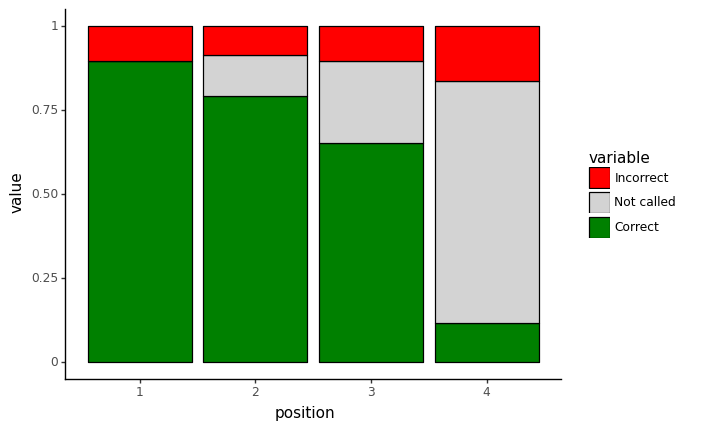

<ggplot: (8775745656397)>

In [20]:

melted['variable'] = melted['variable'].astype('category').cat.reorder_categories(["Incorrect","Not called","Correct"], ordered=True )

(ggplot(melted,aes(x="position",fill="variable",y="value"))+
geom_col(color="black", position="fill")+
scale_fill_manual(["red","lightgray","green"])+ theme_classic()
)
